<a href="https://colab.research.google.com/github/Estefany66/Ciencia-de-Datos/blob/main/Predicci%C3%B3n_de_Ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> **Series Temporales**
A partir de los datos de las ventas del 01-02-2022 al 29-08-2023 de una la empresa Opticas San Francisco, buscamos predecir las ventas para los próximos 15 días a 1 mes.

Esto permitirá mejorar los procesos de compras, previsiones y la toma de decisiones en general.

Los datos ya han sido recolectados, limpiados y transformados.

Se trata del estudio de una serie temporal: Veremos si se trata de una serie estacionaria o no. En caso de no serlo, haremos las transformaciones necesarias, elegiremos el modelo más apropiado, lo probaremos y ajustaremos.



CARGAR LIBRERIAS

In [ ]:
# LIBRERÍAS UTILIZADAS EN EL PROYECTO
# ==============================================================================
!pip install u8darts

# Lectura de directorio
import os
import glob
from pathlib import Path

# Tratamiento de datos
import numpy as np
import pandas as pd
from numpy import log

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

# Herramientas
# ==============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller



# Modelado y Forecasting
# ==============================================================================

import darts

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_residuals_analysis

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import backtesting_forecaster

#from joblib import dump, load

In [3]:
# CARGA DEL ARCHIVO DE DATOS
# ==============================================================================

BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/content')

In [5]:
%%time
df_ventas= pd.read_excel('//content/drive/MyDrive/DATA OPTICA SAN FRANCISCO /Producto_Venta.xlsx')
df_ventas

CPU times: user 899 ms, sys: 10.9 ms, total: 909 ms
Wall time: 921 ms


,num,fecha_comp,cliente,monto,tipo,cod,producto,cantidad,fecha,tasa,monto_soles
0,PC: 00001-000015661,19/01/2022,CLIENTE EVENTUAL,10.0,ve,10005945,PAÑOS ANTIFOGGING 0,1.0,30/08/2023,0,10.0
1,PC: 00001-000015646,14/01/2022,CLIENTE EVENTUAL,10.0,ve,10005945,PAÑOS ANTIFOGGING 0,1.0,30/08/2023,0,10.0
2,PC: 00001-000015643,14/01/2022,CLIENTE EVENTUAL,10.0,ve,10005945,PAÑOS ANTIFOGGING 0,1.0,30/08/2023,0,10.0
3,PC: 00001-000015871,14/03/2022,CLIENTE EVENTUAL,10.0,ve,10005945,PAÑOS ANTIFOGGING 0,2.0,30/08/2023,0,10.0
4,PC: 00001-000015838,4/03/2022,CLIENTE EVENTUAL,10.0,ve,10005945,PAÑOS ANTIFOGGING 0,1.0,30/08/2023,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...
5331,PC 00005-000051634,22/08/2023,PIERO CHALCO MONTES,475.0,ve,51634,ESSILOR EYEZEN BOOST AIRWEAR BLUE UV FILTER SY...,2.0,30/08/2023,0,475.0
5332,PC 00005-000051635,23/08/2023,EDUARDO ARANA VIZCARRA,110.0,ve,51635,MON OFT ARO/COMPLETO ADULTO RAZZA 13833 PLASTI...,1.0,30/08/2023,0,110.0
5333,PC 00005-000051635,23/08/2023,EDUARDO ARANA VIZCARRA,120.0,ve,51635,MON OFT ARO COMPLETO ADULTO PIAZZA PZV10027 AC...,1.0,30/08/2023,0,120.0
5334,PC 00005-000051636,23/08/2023,RICHARD VIZCARRA MEZA,0.0,ve,51636,MONTURA USADA NO ES RESPONSABILIDAD DE LA EMPR...,1.0,30/08/2023,0,0.0


**Estilo de Graficos**

In [6]:
# Estilo de los gráficos
# ==============================================================================
plt.style.use('seaborn-colorblind')
plt.rcParams['lines.linewidth'] = 1.5

In [7]:
# Test de estacionalidad
# Verifica si una serie temporal es estacionaria o no:
# Calcula la media, la desviación estándar y la varianza n tramos de una
# serie temporal; grafica el resultado; realiza el test de Dickey-Fuller
#
# Parámetros:
#     ts: Serie temporal a estudiar
#     n: Número de tramos a estudiar de la serie temporal, 12 por defecto
# ==============================================================================

def test_estacionalidad(ts, n=12):

    # Cálculos de estadísticas
    rol_mean = ts.rolling(n).mean()
    #rol_std = ts.rolling(n).std()
    rol_var = ts.rolling(n).var()

    print(rol_mean.sample(n))
    #print(rol_std.sample(n))
    print(rol_var.sample(n))

    # Gráfico de las estadísticas
    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15,10))

    ts.plot(ax=ax1, color='blue',label='Original', figsize=(15,5))
    rol_mean.plot(ax=ax2, color='green', label='Media', figsize=(15,5))
    #rol_std.plot(ax=ax3, color='red', label = 'Desviación Estándar', figsize=(15,5))
    rol_var.plot(ax=ax3, color='orange', label = 'Varianza', figsize=(15,5))
    #plt.legend(loc='best')
    plt.title('Media, Desviación Estándar y Varianza en diferentes tramos de la Serie Temporal')
    plt.show(block=False)

    # Test Dickey-Fuller:
    print ('Resultados del test Dickey-Fuller:')
    ts = ts.values
    df_test = adfuller(ts, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Estadísticas','p-value','#Lags Utilizados','N° de Observaciones'])
    for key,value in df_test[4].items():
        df_output['Valores críticos (%s)'%key] = value
    print(df_output)

**Estudio** Exploratorio de la Serie **Temporal**

In [21]:
# Creación de la Serie Temporal
# Total de ventas diarias del 01/08/20202 al 31/0108/2023
# ==============================================================================
# Convertir la columna 'fecha_comp' a tipo datetime
df_ventas['fecha_comp'] = pd.to_datetime(df_ventas['fecha_comp'])

# Filtrar las fechas
ts_ventas = df_ventas.query('fecha_comp > "2022-08-02" and fecha_comp < "2023-08-01"').groupby(['fecha_comp']).monto_soles.sum()

ts_ventas = df_ventas.query('fecha_comp > "2022-08-02" and fecha_comp < "2023-08-01"').groupby(['fecha_comp']).monto_soles.sum()
ts_ventas

fecha_comp
2022-08-03        0.0
2022-08-04        0.0
2022-08-06        0.0
2022-08-07      120.0
2022-08-08        0.0
               ...   
2023-07-26     5010.0
2023-07-27     3280.0
2023-07-28     1030.0
2023-07-29     7680.0
2023-07-31    13471.0
Name: monto_soles, Length: 283, dtype: float64

Text(0.5, 0, 'Fecha_camp')

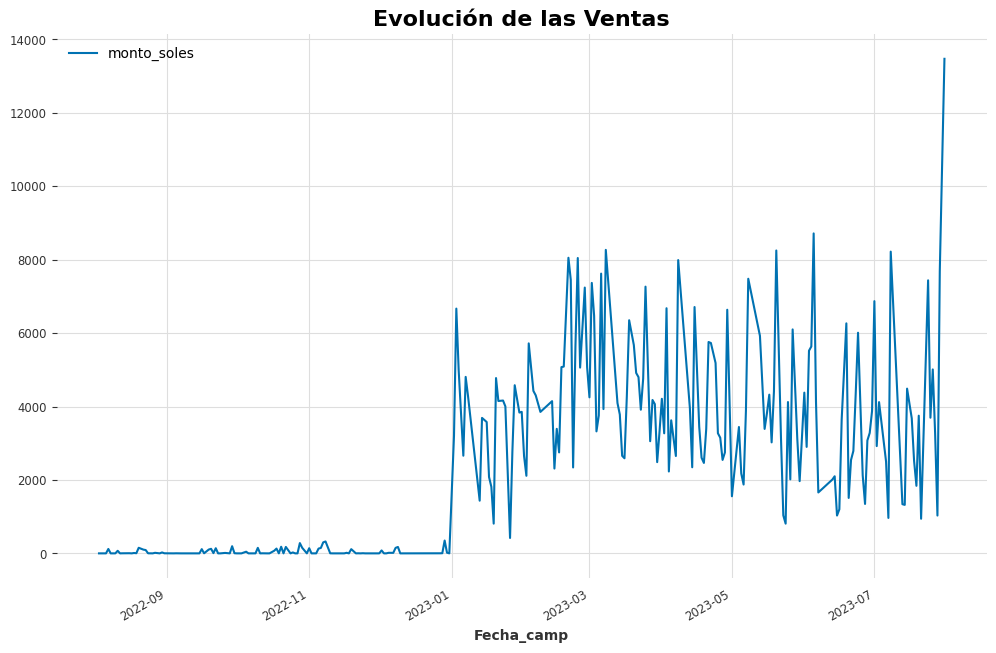

In [22]:
# Evolución de las ventas a lo largo del tiempo
# ==============================================================================
fig, ax = plt.subplots(figsize=(12,8))
ts_ventas.plot(ax=ax)
ax.set_title('Evolución de las Ventas', fontsize=16, weight='bold')
ax.legend()
ax.set_xlabel('Fecha_camp')

**Descomposición** de la **Serie**
**A** simple vista no se observa una tendencia marcada. Tampoco una estacionalidad.

Sin embargo, en toda serie temporal hay tres componentes importantes:

**Estacionalidad**: Cuando los datos siguen un patrón que se repite períodicamente y de manera regular

**Tendencia**: Es el comportamiento de los datos a largo plazo. Puede ser creciente o decreciente

**Ruido**: Son las alteraciones de la serie, pequeñas en su incidencia, y sin una pauta periódica ni tendencial reconocible

Estudiar la descomposición de una serie temporal nos permitirá elegir y optimizar un modelo de predicción.**texto en negrita**

<Axes: xlabel='fecha_comp'>

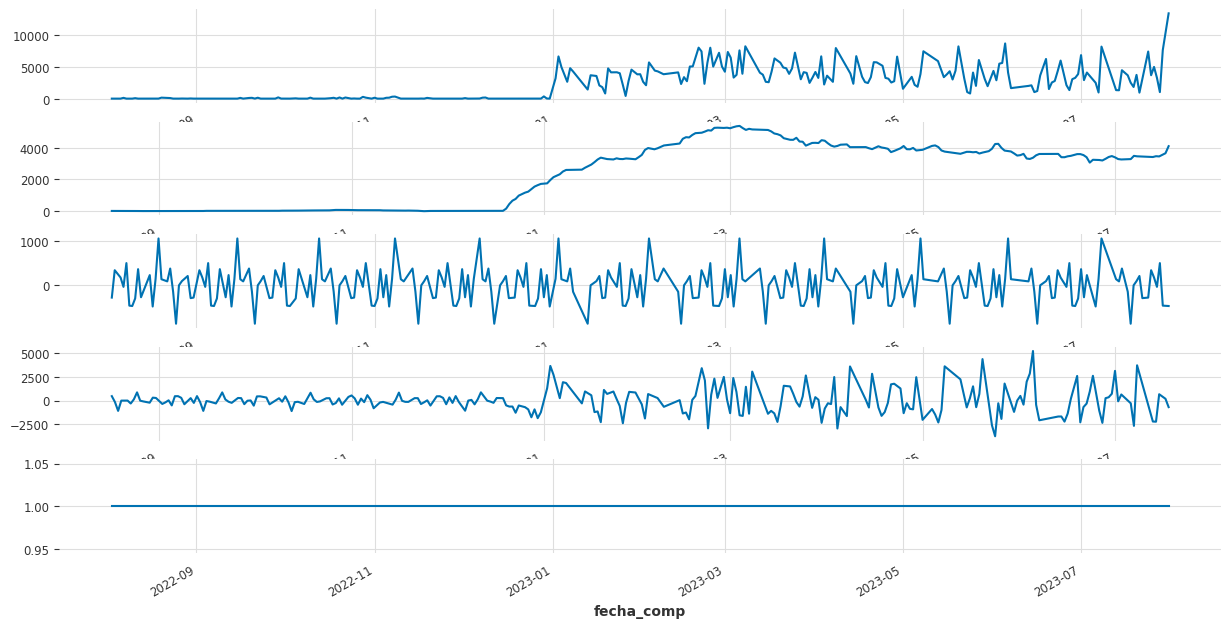

In [24]:
# Descomposición de la serie en Tendencia, Estacionalidad y Ruido
# ==============================================================================
descomposicion = seasonal_decompose(ts_ventas, model='additive', period=23)

fig, (ax1,ax2,ax3, ax4, ax5) = plt.subplots(5,1, figsize=(15,8))
descomposicion.observed.plot(ax=ax1)
descomposicion.trend.plot(ax=ax2)
descomposicion.seasonal.plot(ax=ax3)
descomposicion.resid.plot(ax=ax4)
descomposicion.weights.plot(ax=ax5)

#descomposicion.plot()

También podemos ver que la gráfica residual muestra cero. Este es un buen ejemplo en el que la descomposición ingenua o clásica no pudo separar el ruido que agregamos de la tendencia lineal.

El método de descomposición ingenuo es simple y hay descomposiciones más avanzadas disponibles, como la descomposición estacional y de tendencia mediante descomposición Loess o STL.

 **Estudio** de la **Estacionalidad**

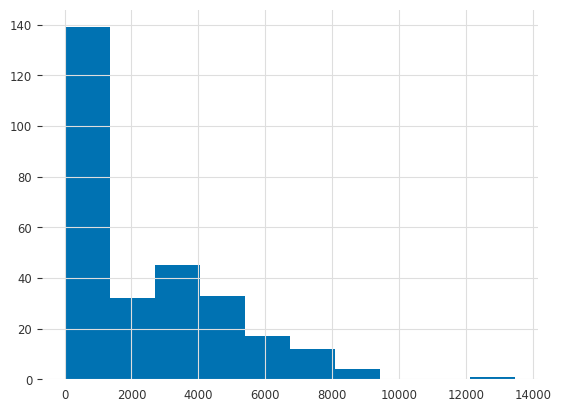

In [25]:
ts_ventas.hist()
plt.show()

fecha_comp
2022-09-20      28.916667
2022-08-10            NaN
2022-10-19      33.083333
2022-08-31      33.500000
2022-11-05      60.583333
2023-06-26    2964.583333
2023-07-02    3390.916667
2023-04-27    3883.333333
2023-02-25    4945.166667
2022-09-23      41.083333
2023-04-29    3910.833333
2022-12-20      28.500000
Name: monto_soles, dtype: float64
fecha_comp
2023-01-04    5.493291e+06
2022-11-06    8.780152e+03
2023-05-22    3.901888e+06
2022-12-11    3.997538e+03
2022-11-18    1.486245e+04
2023-04-13    2.865413e+06
2023-03-30    1.760646e+06
2023-03-05    3.406072e+06
2022-09-16    1.095720e+03
2022-11-14    1.476681e+04
2023-02-08    2.006357e+06
2023-03-17    4.059143e+06
Name: monto_soles, dtype: float64


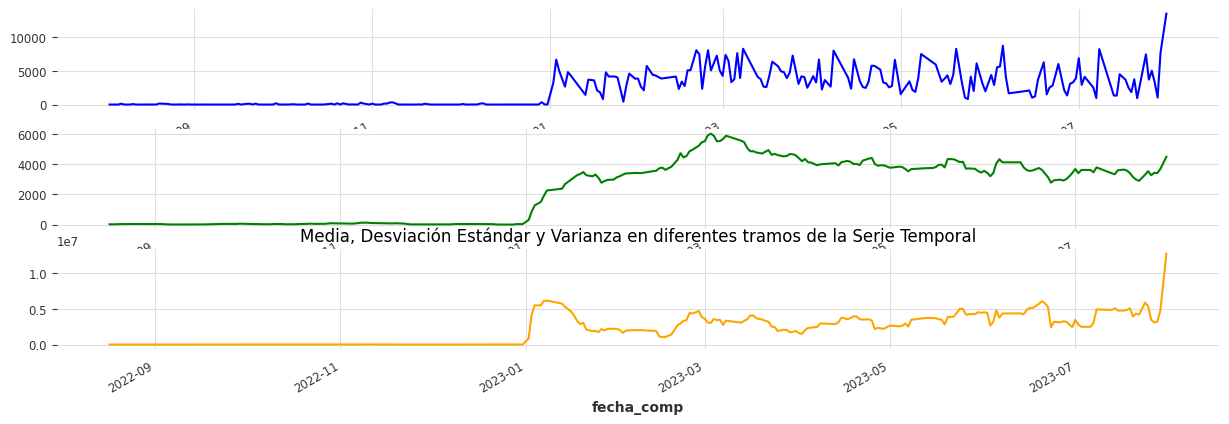

Resultados del test Dickey-Fuller:
Test Estadísticas          -0.804434
p-value                     0.817816
#Lags Utilizados           11.000000
N° de Observaciones       271.000000
Valores críticos (1%)      -3.454713
Valores críticos (5%)      -2.872265
Valores críticos (10%)     -2.572485
dtype: float64


In [26]:
test_estacionalidad(ts_ventas)

**Con** un p-value **texto en negrita**< 0.05 ** **texto en negrita**confirmamos** la no presencia de una raíz unitaria (rechazamos la hipótesis nula) y por lo tanto la serie es estacionaria.**texto en negrita**

**Estudio de Autocorrelación**

In [27]:
df_ventas = ts_ventas.reset_index()
df_ventas

,fecha_comp,monto_soles
0,2022-08-03,0.0
1,2022-08-04,0.0
2,2022-08-06,0.0
3,2022-08-07,120.0
4,2022-08-08,0.0
...,...,...
278,2023-07-26,5010.0
279,2023-07-27,3280.0
280,2023-07-28,1030.0
281,2023-07-29,7680.0


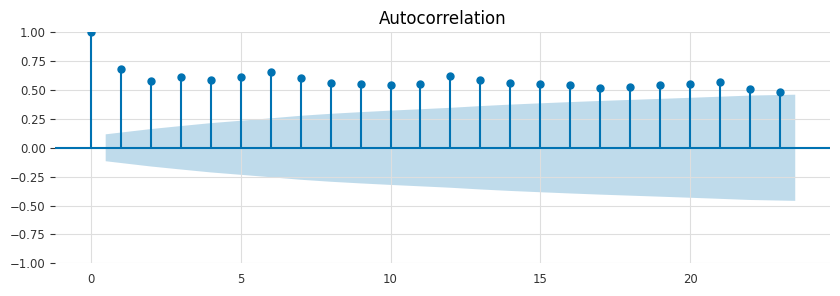

In [28]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))

plot_acf(df_ventas['monto_soles'], ax=ax, lags=23)
plt.show()

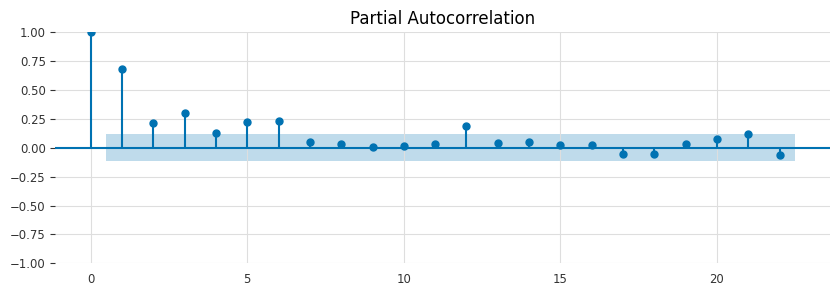

In [29]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(df_ventas['monto_soles'], ax=ax, lags=22, method='ywm')
plt.show()

**Podemos observar en los gráficos ACF y PACF que rápidamente la autocorrelación cae a 0, es decir, que existe muy poca o nula correlación entre los datos. Esto confirma de nuevo que la serie es estacionaria.**

## Transformación de la Serie Temporal

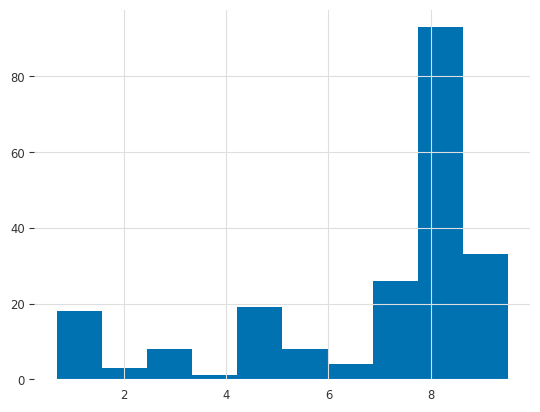

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Filtrar valores no válidos (cero o negativos)
valid_values = ts_ventas[ts_ventas > 0]

# Aplicar logaritmo solo a valores válidos
log_values = np.log(valid_values)

# Generar el histograma
plt.hist(log_values)
plt.show()



# **Modelado**

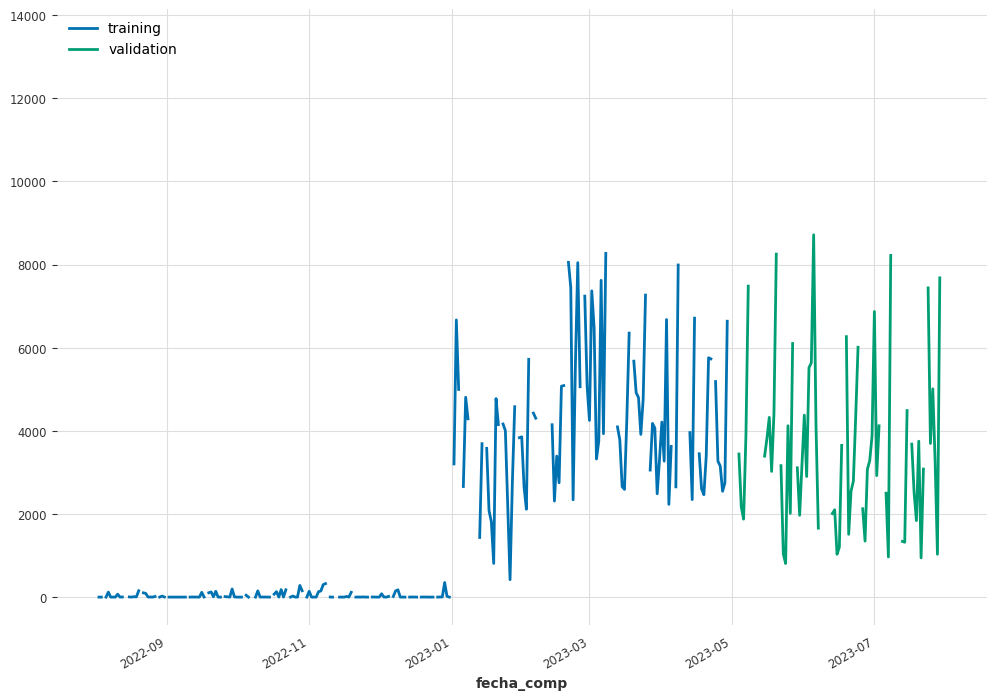

In [39]:
## Importing Libraries
#import sys
#import time
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#from datetime import datetime
#from functools import reduce

## Load the pre-loaded Dataset
series = TimeSeries.from_dataframe(df_ventas, time_col='fecha_comp', fill_missing_dates=True, freq='d')

## Split train and test data
train, val = series.split_before(0.75)

fig, ax = plt.subplots(figsize=(12,8))
train.plot(label='training')
val.plot(label='validation')
plt.legend()

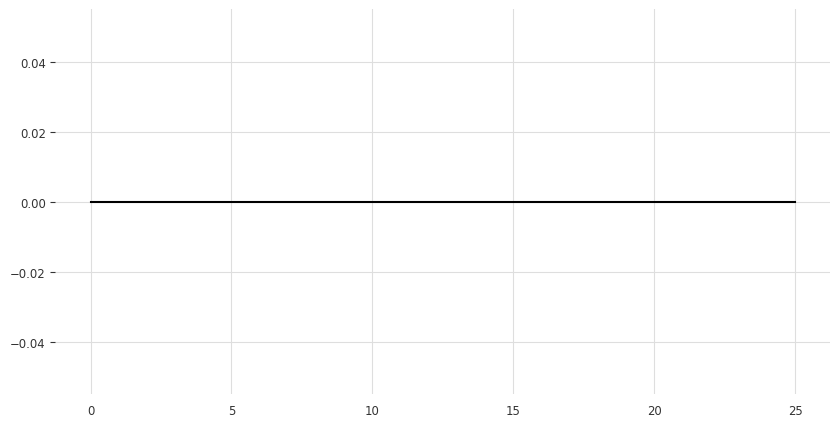

In [40]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=3, alpha=0.05)

<Axes: xlabel='fecha_comp'>

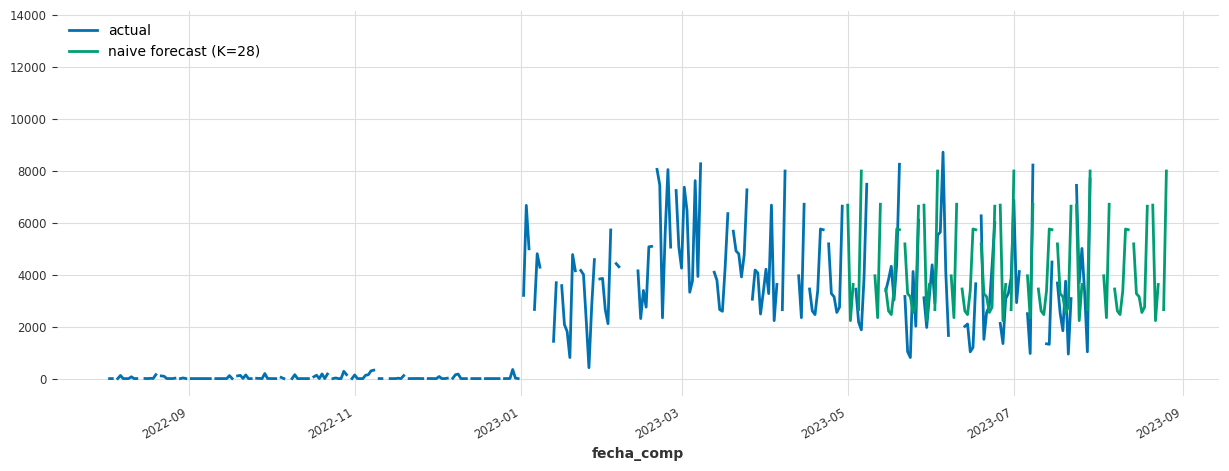

In [45]:
naive_model = NaiveSeasonal(K=28)
naive_model.fit(train)
naive_forecast = naive_model.predict(120)

fig, ax = plt.subplots(figsize=(15,5))
series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=28)")

## **Montaje de varios modelos y comprobación del MAPE**

model NaiveSeasonal() obtains MAPE: nan%
model Prophet() obtains MAPE: 172.08%
model ARIMA() obtains MAPE: 69.90%
The MAPE is: nan, with theta = 1.


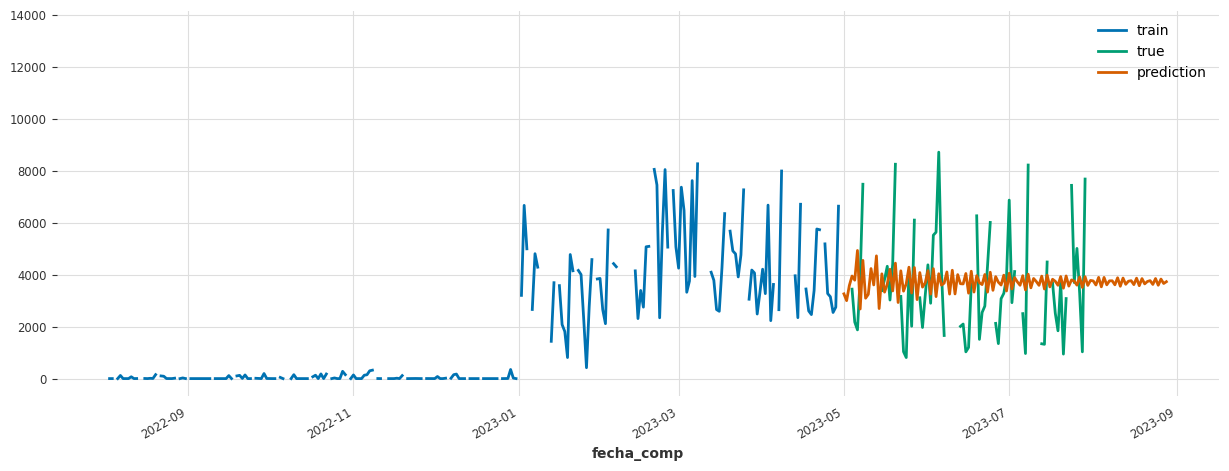

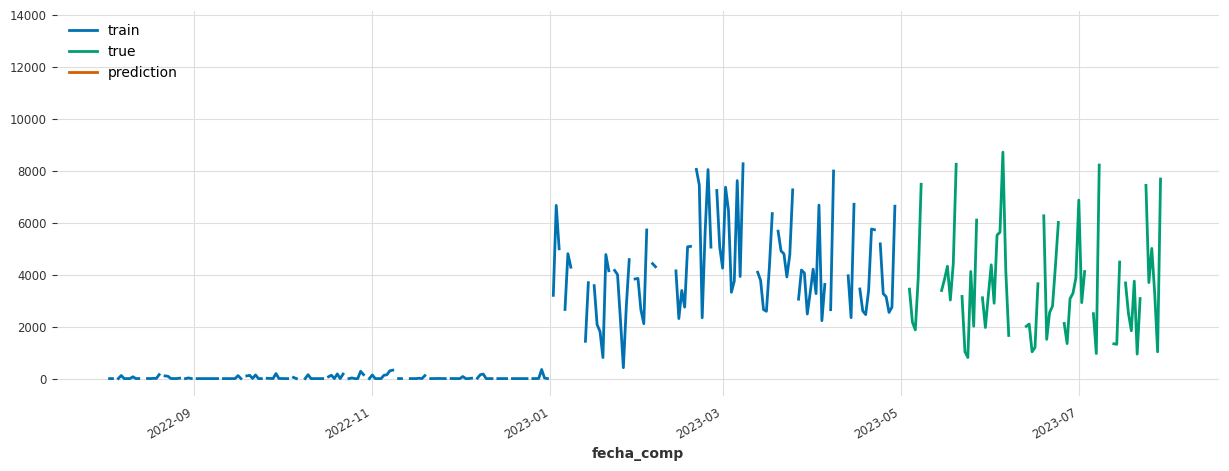

In [46]:
## Montaje de varios modelos
#=====================================================================
#comprobación del MAPE(Error Medio de Porcentaje Absoluto)
def eval_model(model):
    global forecast
    model.fit(train)
    forecast = model.predict(120)
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

# El método .fit() es comúnmente utilizado en modelos de series temporales para
#entrenar el modelo.


eval_model(NaiveSeasonal())
eval_model(Prophet())
eval_model(ARIMA())


## Visualizando el resultado de previsión theta

fig, ax = plt.subplots(figsize=(15,5))
train.plot(label='train')
val.plot(label='true')
forecast.plot(label='prediction')
plt.legend();

## Ajustando el parámetro theta para ver si MAPE se reduce
## Busque el mejor parámetro theta probando 50 valores diferentes
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 1

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(120)
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

#Ajustar y predecir nuevamente usando el mejor valor theta
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(120)

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

## Visualize
fig, ax = plt.subplots(figsize=(15,5))
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend();